In [1]:
# use this code to keep cloba alive basically clicks so colab doesn't turn off 
# (usually turns off fter 90 minutes of idle)
#function ClickConnect(){
#    console.log("Working");
# document.querySelector("colab-toolbar-button#connect").click()
#}setInterval(ClickConnect,60000)

# Python Modules
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt
import time
import datetime
import random

from tqdm import trange
from tqdm.notebook import tqdm

from time import sleep

import glob

from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

from skimage.util import random_noise
from skimage.filters import gaussian

In [3]:
# constants and paths to our data

IMG_WIDTH, IMG_HEIGHT = 256, 256
NUM_CHANNELS = 3
NEW_IMAGE_SHAPE = (256, 256, 3)
NEW_MASK_SHAPE = (256, 256)

train_path = 'mass_roads_cropped/mass_roads_bucket_050520/train'
valid_path = 'mass_roads_cropped/mass_roads_bucket_050520/valid'
test_path = 'mass_roads_cropped/mass_roads_bucket_050520/test'
checkpoint_path = 'checkpoints'
model_save_path = '/checkpoints/UNet_052820.pt'

channel_wise_mean = (0.3711, 0.4098, 0.4071)
channel_wise_stdev = (0.2742, 0.2638, 0.2709)

In [4]:
# set up tensorboard

# Install latest Tensorflow build
import tensorflow as tf
from tensorflow import summary
%load_ext tensorboard

current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

In [5]:
## https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

from datetime import datetime

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            print("saving checkpoint")
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        now = datetime.now()
        date_time = now.strftime("%H_%M_%S")
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, checkpoint_path + '/' + date_time + '_checkpoint.pt')
        self.val_loss_min = val_loss

In [6]:
# define custom dataset class which is interpretable by DataLoader

#augmentation: https://debuggercafe.com/image-augmentation-using-pytorch-and-albumentations/
# and https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

class CustomDataset():
    def __init__(self, image_paths, target_paths):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.image_transforms = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize(channel_wise_mean, channel_wise_stdev)])
        self.mask_transforms = transforms.ToTensor()

    def __getitem__(self, index):
        image = np.array(plt.imread(self.image_paths[index])) / 255.0
        mask = np.array(plt.imread(self.target_paths[index])) /255.0
        
        t_image = self.image_transforms(image) 
        t_mask = self.mask_transforms(mask) 
        t_mask = t_mask.squeeze()
        return t_image, t_mask

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)

In [7]:
# get all the image and mask path and number of images
def generate_loader(path, batch_size):
  folder_sat = glob.glob(path + "/sat/*.tif")
  folder_map = glob.glob(path + "/map/*.tif")
  len_data = len(folder_sat)
  print(len_data)
  sat_paths = folder_sat
  map_paths = folder_map
  dataset = CustomDataset(sat_paths, map_paths)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
  return loader

BATCH_SIZE = 16

valid_loader = generate_loader(valid_path, BATCH_SIZE)
test_loader = generate_loader(test_path, BATCH_SIZE)
train_loader = generate_loader(train_path, BATCH_SIZE)

350
1225
18255


In [8]:
# https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        n_classes=1,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [9]:
def train():
    # training 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(in_channels=3, n_classes=2, padding=True).to(device)
    optim = torch.optim.Adam(model.parameters())
    
    print(f"training on device: {device}")

    dataloader = train_loader
    val_dataloader = valid_loader
    
    epochs = 1000
    patience = 5

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in tqdm(range(epochs)):
        tic = time.perf_counter()

        train_losses = []
        N = 0
        model.train()
        for X, y in tqdm(dataloader):
            X = X.to(device, dtype=torch.float)  # [N, 3, H, W]
            y = y.to(device, dtype=torch.float)  # [N, H, W] with class indices (0, 1)
            n = X.shape[0]
            N += n # increment counter of training examples
            prediction = model(X) # [N, 1, H, W]
            loss = F.cross_entropy(prediction, y.long()) * n # multiply by batchsize since cross_entropy takes the average
            train_losses.append(loss)
            optim.zero_grad()
            loss.backward()
            optim.step()

        avg_training_loss = np.sum(np.array(train_losses)) / N 

        ## compute validation error
        val_losses = []
        N = 0
        model.eval()
        with torch.no_grad():
            for X, y in tqdm(val_dataloader):
                X = X.to(device, dtype=torch.float)  # [N, 3, H, W]
                y = y.to(device, dtype=torch.float)  # [N, H, W] with class indices (0, 1)
                n = X.shape[0]
                prediction = model(X) # [N, 1, H, W]
                
                loss = F.cross_entropy(prediction, y.long()) * n
                val_losses.append(loss)
                if N == 0:
                    fig = plt.figure(epoch)
                    ax1 = fig.add_subplot(1,3,1)
                    ax2 = fig.add_subplot(1,3,2)
                    ax3 = fig.add_subplot(1,3,3)
                    ax1.imshow(X[0].permute(1,2,0).cpu().numpy()*channel_wise_stdev + channel_wise_mean)
                    ax2.imshow(y[0].cpu().numpy(), cmap='gray')
                    ax3.imshow(prediction[0].permute(1,2,0)[:,:,1].cpu().numpy(), cmap='gray')
                    fig.show()
                    plt.pause(0.05)
                    
                N += n
        
        avg_val_loss = np.sum(np.array(val_losses)) / N

        toc = time.perf_counter()
        print(f"Epoch {epoch}: Train Loss = {avg_training_loss}, Validation Loss = {avg_val_loss}, and took {toc - tic:0.4f} seconds")

        with train_summary_writer.as_default():
          tf.summary.scalar('training loss', avg_training_loss.item(), step=epoch)
          tf.summary.scalar('validation loss', avg_val_loss.item(), step=epoch)

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            break
        
    # save model
    torch.save(model, model_save_path)

training on device: cuda


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


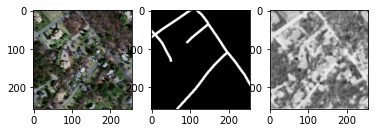


Epoch 0: Train Loss = 2.715606451034546, Validation Loss = 0.19923126697540283, and took 1625.7506 seconds
saving checkpoint
Validation loss decreased (inf --> 0.199231).  Saving model ...


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNetConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNetUpBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


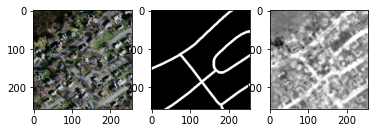


Epoch 1: Train Loss = 0.1458238810300827, Validation Loss = 0.17933769524097443, and took 1595.5940 seconds
Validation loss decreased (0.199231 --> 0.179338).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


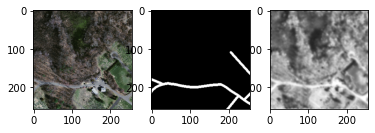


Epoch 2: Train Loss = 0.15612046420574188, Validation Loss = 0.2205253541469574, and took 1601.7197 seconds
EarlyStopping counter: 1 out of 5


hey


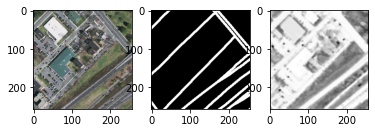


Epoch 3: Train Loss = 0.1495189517736435, Validation Loss = 0.1856631487607956, and took 1599.0180 seconds
EarlyStopping counter: 2 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


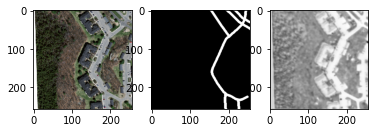


Epoch 4: Train Loss = 0.14452259242534637, Validation Loss = 0.18318234384059906, and took 1599.3217 seconds
EarlyStopping counter: 3 out of 5


hey


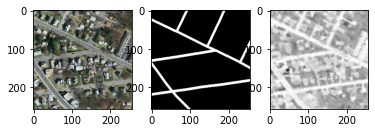


Epoch 5: Train Loss = 0.13963168859481812, Validation Loss = 0.17617446184158325, and took 1600.4229 seconds
Validation loss decreased (0.179338 --> 0.176174).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


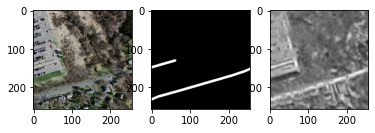


Epoch 6: Train Loss = 0.12856915593147278, Validation Loss = 0.14798182249069214, and took 1603.2507 seconds
Validation loss decreased (0.176174 --> 0.147982).  Saving model ...


hey


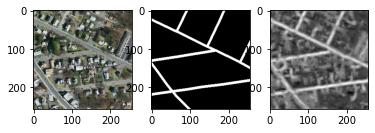


Epoch 7: Train Loss = 0.1178601011633873, Validation Loss = 0.1376430243253708, and took 1605.2321 seconds
Validation loss decreased (0.147982 --> 0.137643).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


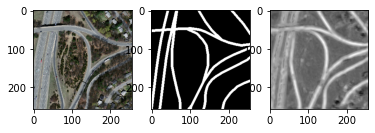


Epoch 8: Train Loss = 0.11220481246709824, Validation Loss = 0.1309323012828827, and took 1606.2181 seconds
Validation loss decreased (0.137643 --> 0.130932).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


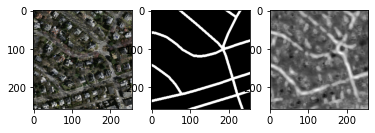


Epoch 9: Train Loss = 0.10806230455636978, Validation Loss = 0.13094152510166168, and took 1607.8363 seconds
EarlyStopping counter: 1 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


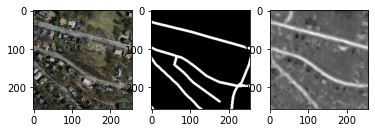


Epoch 10: Train Loss = 0.10519295930862427, Validation Loss = 0.12398849427700043, and took 1615.7624 seconds
Validation loss decreased (0.130932 --> 0.123988).  Saving model ...


hey


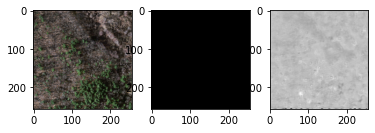


Epoch 11: Train Loss = 0.1027095839381218, Validation Loss = 0.12073559314012527, and took 1614.5489 seconds
Validation loss decreased (0.123988 --> 0.120736).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


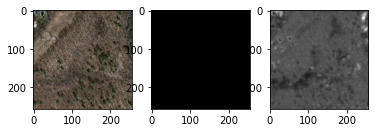


Epoch 12: Train Loss = 0.10120294988155365, Validation Loss = 0.11393570899963379, and took 1613.0123 seconds
Validation loss decreased (0.120736 --> 0.113936).  Saving model ...


hey


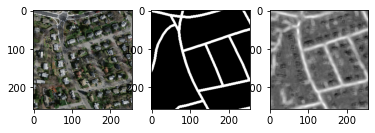


Epoch 13: Train Loss = 0.09916073083877563, Validation Loss = 0.11100950837135315, and took 1609.9874 seconds
Validation loss decreased (0.113936 --> 0.111010).  Saving model ...


hey


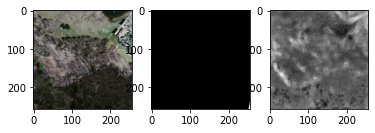


Epoch 14: Train Loss = 0.09779424965381622, Validation Loss = 0.11272498965263367, and took 1609.5794 seconds
EarlyStopping counter: 1 out of 5


hey


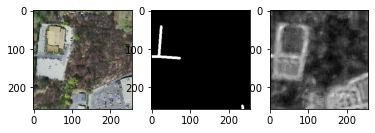


Epoch 15: Train Loss = 0.09605320543050766, Validation Loss = 0.10807006806135178, and took 1609.7289 seconds
Validation loss decreased (0.111010 --> 0.108070).  Saving model ...


hey


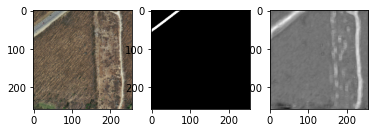


Epoch 16: Train Loss = 0.09504767507314682, Validation Loss = 0.1068129688501358, and took 1608.4744 seconds
Validation loss decreased (0.108070 --> 0.106813).  Saving model ...


hey


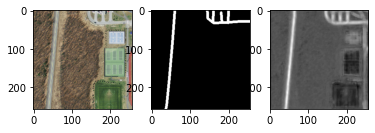


Epoch 17: Train Loss = 0.09357145428657532, Validation Loss = 0.1057097390294075, and took 1613.2697 seconds
Validation loss decreased (0.106813 --> 0.105710).  Saving model ...


hey


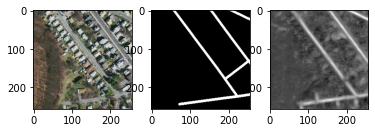


Epoch 18: Train Loss = 0.0924697071313858, Validation Loss = 0.10317888110876083, and took 1613.3414 seconds
Validation loss decreased (0.105710 --> 0.103179).  Saving model ...


hey


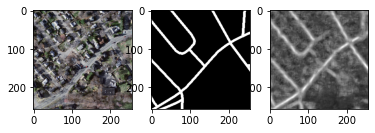


Epoch 19: Train Loss = 0.091552734375, Validation Loss = 0.10459897667169571, and took 1607.8248 seconds
EarlyStopping counter: 1 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


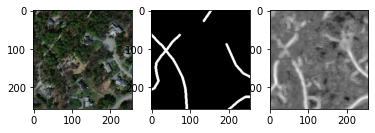


Epoch 20: Train Loss = 0.0910349115729332, Validation Loss = 0.09946168214082718, and took 1607.3096 seconds
Validation loss decreased (0.103179 --> 0.099462).  Saving model ...


hey


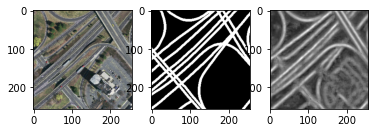


Epoch 21: Train Loss = 0.08993002772331238, Validation Loss = 0.09925150126218796, and took 1606.3561 seconds
Validation loss decreased (0.099462 --> 0.099252).  Saving model ...


hey


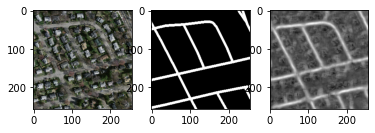


Epoch 22: Train Loss = 0.08915610611438751, Validation Loss = 0.09983448684215546, and took 1605.6250 seconds
EarlyStopping counter: 1 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


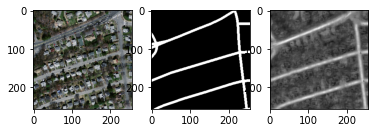


Epoch 23: Train Loss = 0.08885390311479568, Validation Loss = 0.10239250212907791, and took 1605.5117 seconds
EarlyStopping counter: 2 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


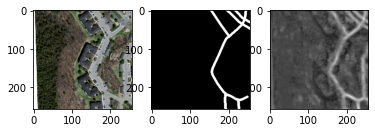


Epoch 24: Train Loss = 0.08823857456445694, Validation Loss = 0.09658144414424896, and took 1608.1868 seconds
Validation loss decreased (0.099252 --> 0.096581).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


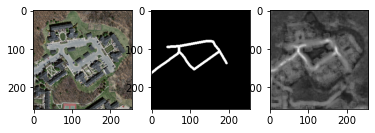


Epoch 25: Train Loss = 0.08756250888109207, Validation Loss = 0.1010982096195221, and took 1609.5776 seconds
EarlyStopping counter: 1 out of 5


hey


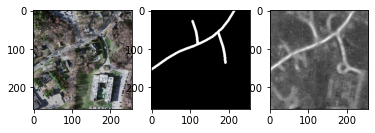


Epoch 26: Train Loss = 0.08785342425107956, Validation Loss = 0.0997377559542656, and took 1608.5865 seconds
EarlyStopping counter: 2 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


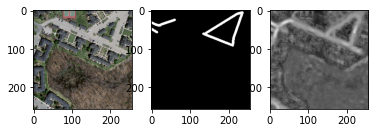


Epoch 27: Train Loss = 0.08694060146808624, Validation Loss = 0.09753552079200745, and took 1607.1873 seconds
EarlyStopping counter: 3 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


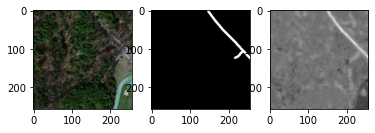


Epoch 28: Train Loss = 0.08688846975564957, Validation Loss = 0.09606931358575821, and took 1606.8608 seconds
Validation loss decreased (0.096581 --> 0.096069).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


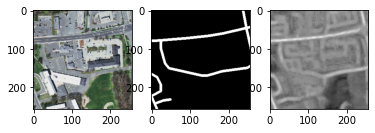


Epoch 29: Train Loss = 0.0861058235168457, Validation Loss = 0.09495358914136887, and took 1607.8831 seconds
Validation loss decreased (0.096069 --> 0.094954).  Saving model ...


hey


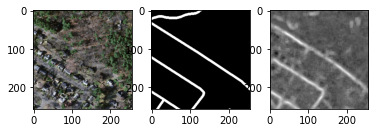


Epoch 30: Train Loss = 0.08601678162813187, Validation Loss = 0.09544328600168228, and took 1606.8541 seconds
EarlyStopping counter: 1 out of 5


hey


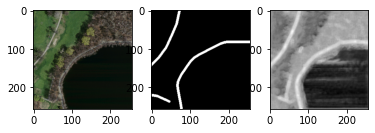


Epoch 31: Train Loss = 0.08573432266712189, Validation Loss = 0.09816881269216537, and took 1607.5502 seconds
EarlyStopping counter: 2 out of 5


hey


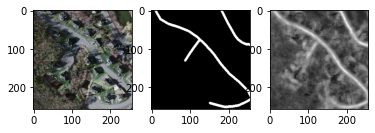


Epoch 32: Train Loss = 0.08528374135494232, Validation Loss = 0.09416284412145615, and took 1607.5627 seconds
Validation loss decreased (0.094954 --> 0.094163).  Saving model ...


hey


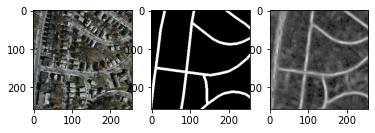


Epoch 33: Train Loss = 0.08500159531831741, Validation Loss = 0.09534461796283722, and took 1605.4713 seconds
EarlyStopping counter: 1 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


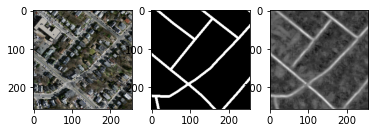


Epoch 34: Train Loss = 0.08497242629528046, Validation Loss = 0.09458676725625992, and took 1606.1041 seconds
EarlyStopping counter: 2 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


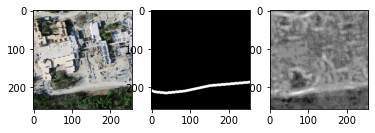


Epoch 35: Train Loss = 0.0848160833120346, Validation Loss = 0.09411237388849258, and took 1605.3169 seconds
Validation loss decreased (0.094163 --> 0.094112).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


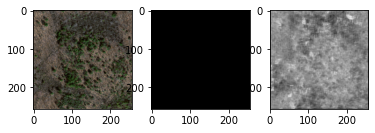


Epoch 36: Train Loss = 0.08467374742031097, Validation Loss = 0.0934508815407753, and took 1606.7740 seconds
Validation loss decreased (0.094112 --> 0.093451).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


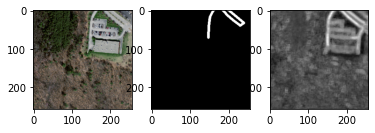


Epoch 37: Train Loss = 0.0843455120921135, Validation Loss = 0.09311536699533463, and took 1605.2612 seconds
Validation loss decreased (0.093451 --> 0.093115).  Saving model ...


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


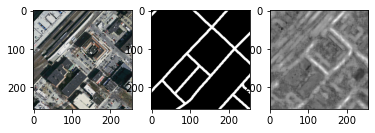


Epoch 38: Train Loss = 0.0846458151936531, Validation Loss = 0.09379389137029648, and took 1605.6290 seconds
EarlyStopping counter: 1 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


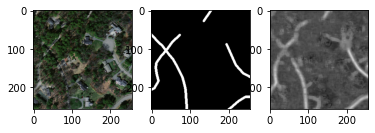


Epoch 39: Train Loss = 0.08373968303203583, Validation Loss = 0.09575985372066498, and took 1605.2481 seconds
EarlyStopping counter: 2 out of 5


hey


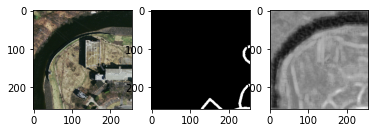


Epoch 40: Train Loss = 0.08400916308164597, Validation Loss = 0.09238111227750778, and took 1605.2886 seconds
Validation loss decreased (0.093115 --> 0.092381).  Saving model ...


hey


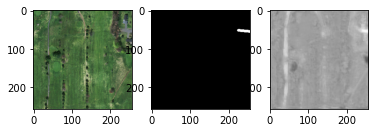


Epoch 41: Train Loss = 0.0836707353591919, Validation Loss = 0.09658528864383698, and took 1605.5112 seconds
EarlyStopping counter: 1 out of 5


hey


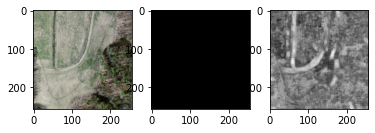


Epoch 42: Train Loss = 0.08444754034280777, Validation Loss = 0.09259452670812607, and took 1605.1343 seconds
EarlyStopping counter: 2 out of 5


hey


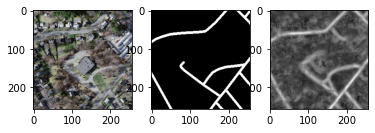


Epoch 43: Train Loss = 0.08514652401208878, Validation Loss = 0.09256744384765625, and took 1604.8944 seconds
EarlyStopping counter: 3 out of 5


hey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


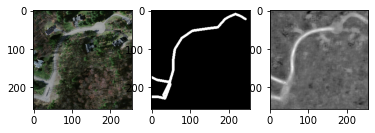


Epoch 44: Train Loss = 0.08334001153707504, Validation Loss = 0.09446918964385986, and took 1606.5130 seconds
EarlyStopping counter: 4 out of 5


hey


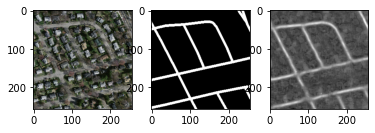


Epoch 45: Train Loss = 0.08421438932418823, Validation Loss = 0.09287991374731064, and took 1606.1945 seconds
EarlyStopping counter: 5 out of 5



FileNotFoundError: [Errno 2] No such file or directory: '/checkpoints/UNet_052820.pt'

In [9]:
train()

In [10]:
# At test time, restart the runtime because cuda runs out of memory
model = torch.load("checkpoints/23_36_06_checkpoint.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


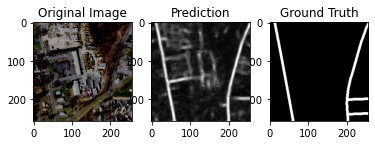

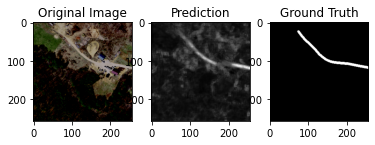

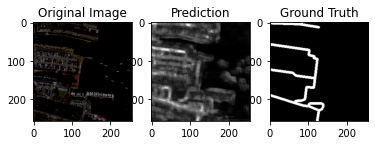

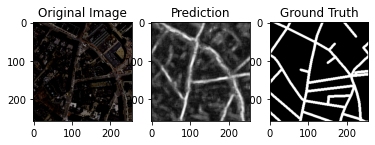

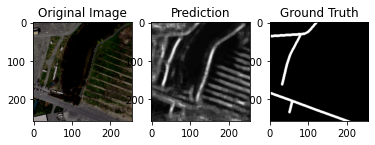

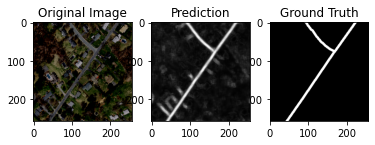

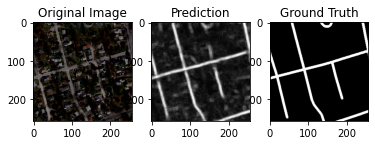

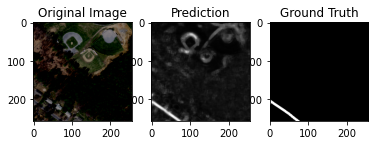

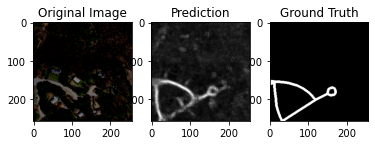

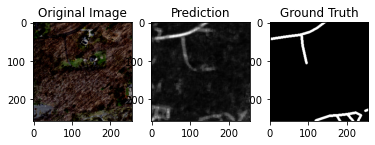

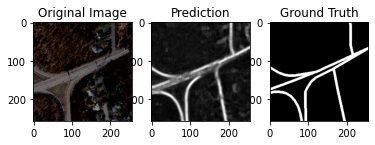

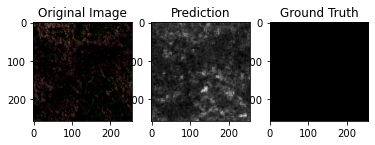

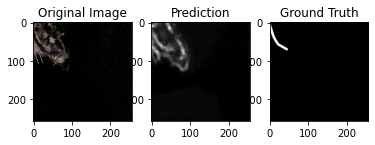

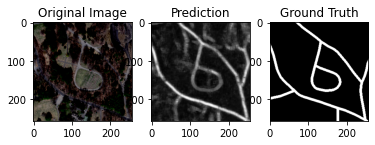

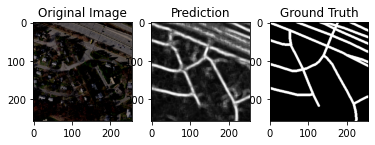

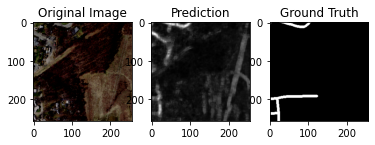

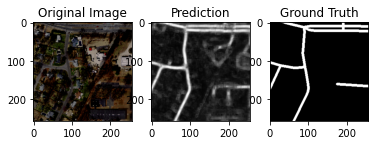

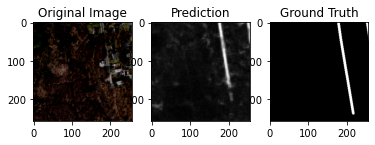

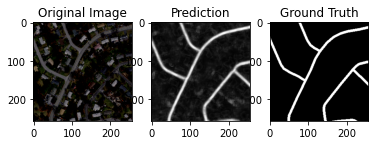

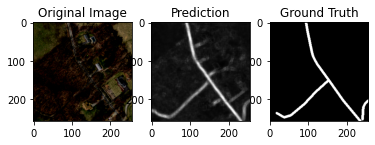

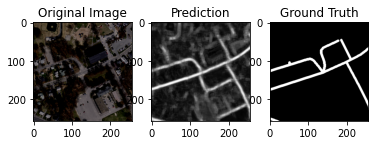

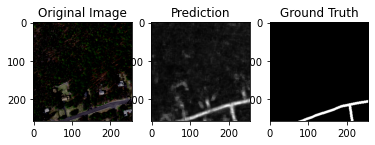

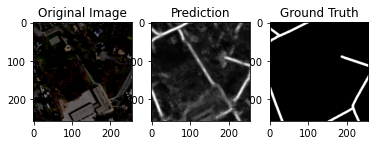

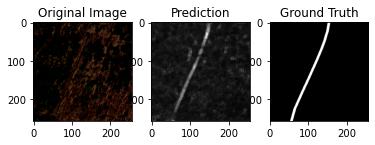

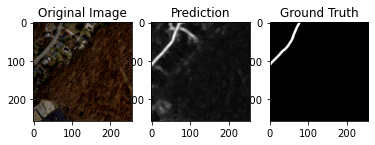

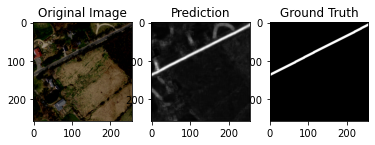

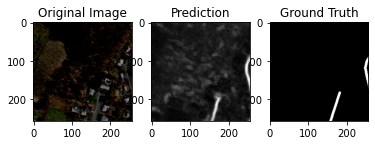

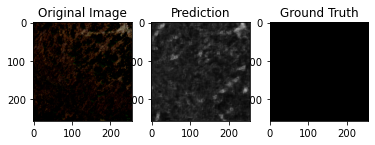

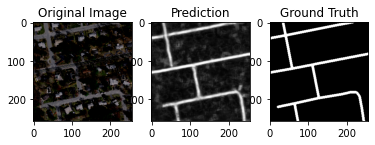

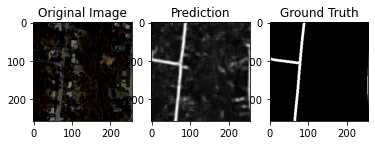

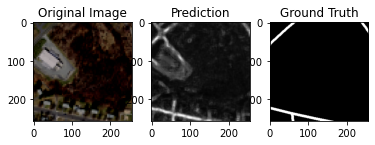

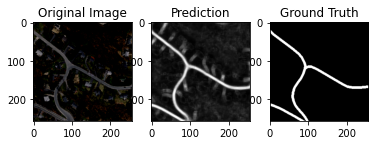

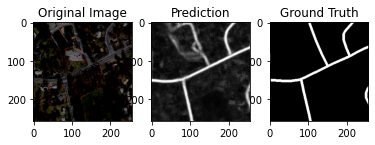

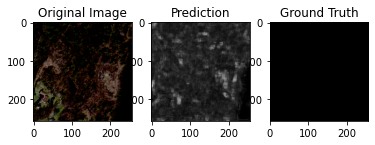

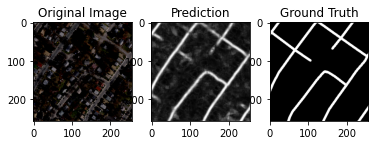

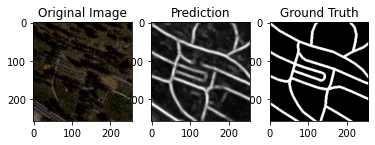

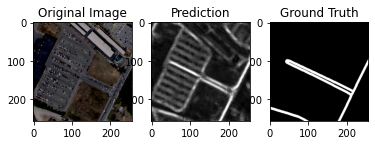

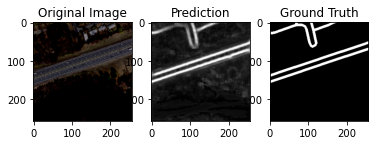

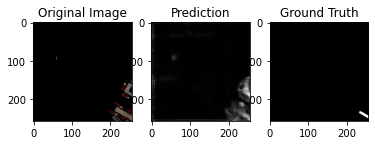

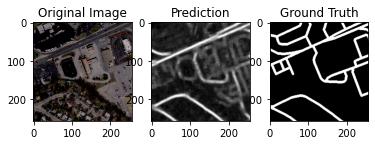

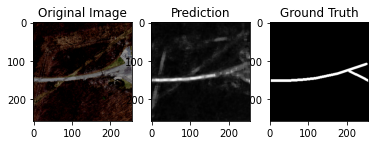

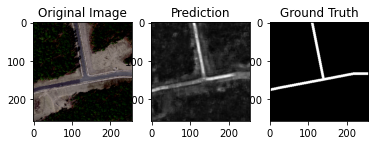

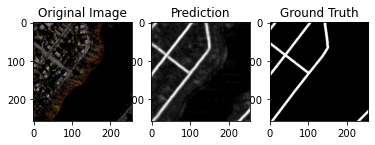

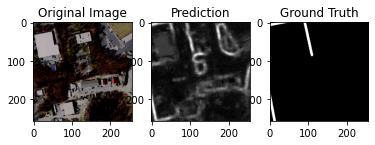

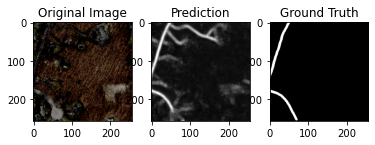

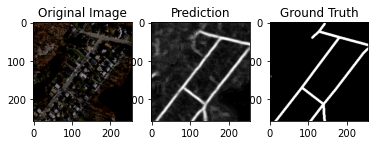

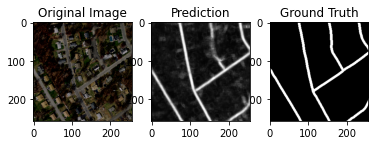

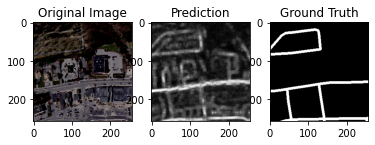

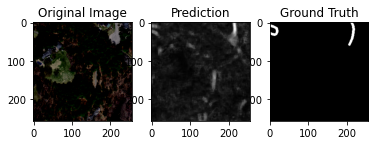

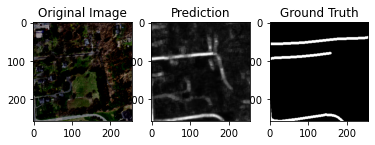

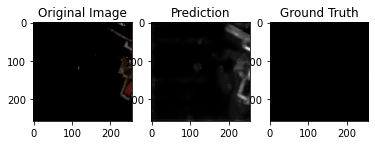

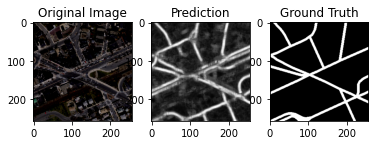

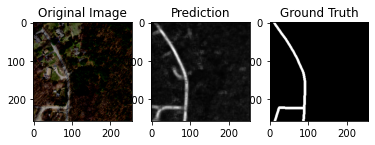

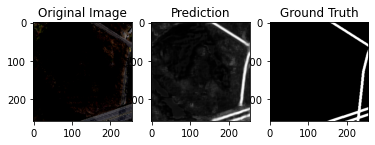

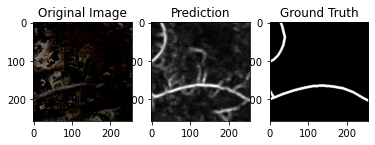

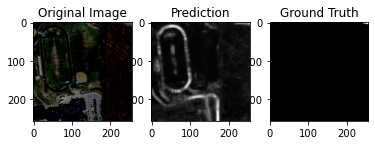

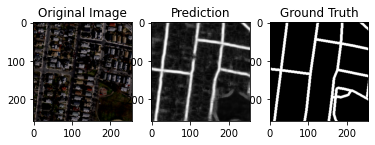

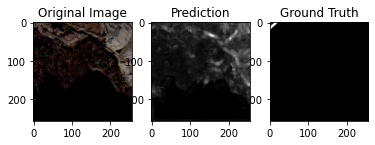

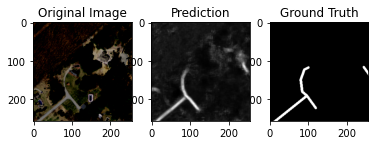

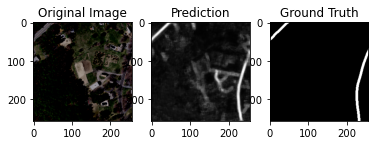

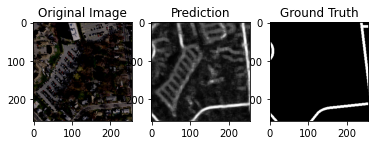

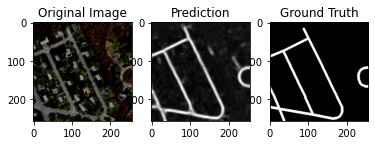

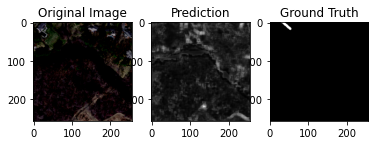

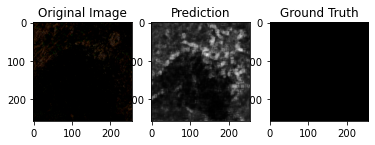

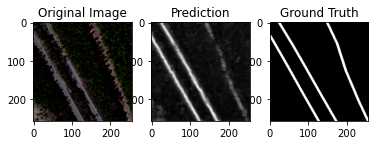

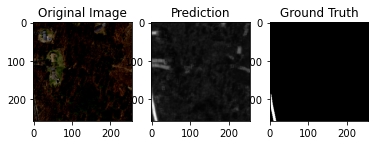

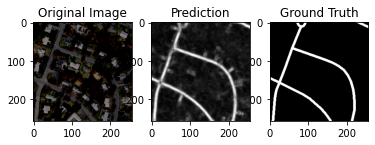

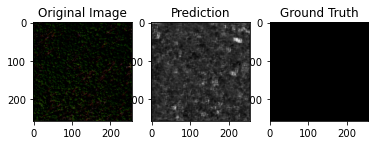

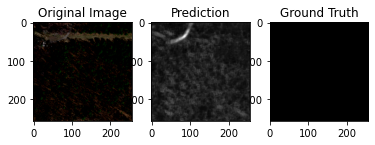

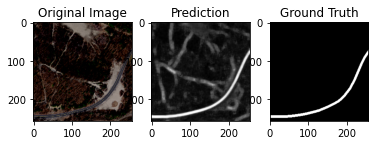

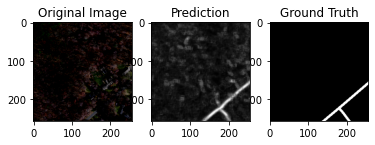

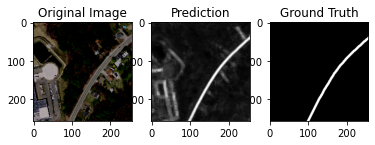

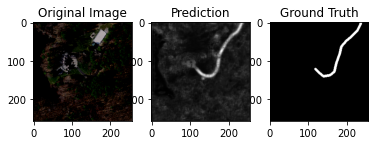

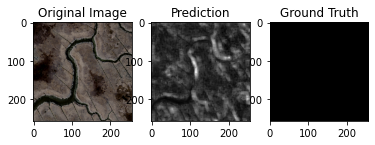

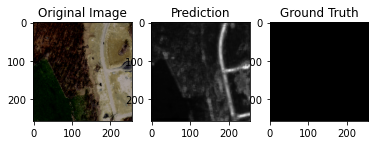

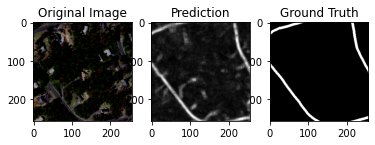

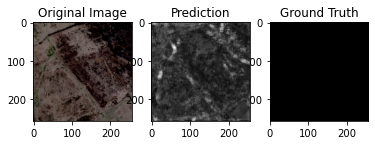

In [17]:
# test model

# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_metrics.html#sphx-glr-auto-examples-segmentation-plot-metrics-py
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_losses = []
rand_error = []
pixel_error = []
N = 0
THRESHOLD = 0.5
counter = 0

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model.eval()
with torch.no_grad():
    for X, y in tqdm(test_loader):
        tic = time.perf_counter()

        X = X.to(device, dtype=torch.float)  # [N, 3, H, W]
        y = y.to(device, dtype=torch.float)  # [N, H, W] with class indices (0, 1)
        n = X.shape[0]
        N += n
        prediction = model(X) # [N, 1, H, W]

        # compute loss
        #loss = F.cross_entropy(prediction, y.long()) * n
        #test_losses.append(loss)

        predicted_mask_1 = prediction[5].permute(1,2,0)[:,:,1].cpu().numpy()
        predicted_mask_sigmoid = sigmoid(predicted_mask_1)
        predicted_mask_threshold = predicted_mask_sigmoid.copy()
        #predicted_mask_threshold[predicted_mask_threshold>THRESHOLD] = 1
        #predicted_mask_threshold[predicted_mask_threshold<=THRESHOLD] = 0
        
        # Plot Predictions
        fig = plt.figure(counter)
        fig.subplots_adjust(hspace=0.4)
        fig.subplots_adjust(hspace=0.4)
        ax1 = fig.add_subplot(1,3,1)
        ax1.set_title('Original Image')
        ax1.imshow((X[5].permute(1,2,0).cpu().numpy() + np.array(channel_wise_mean))*np.array(channel_wise_stdev))
        ax2 = fig.add_subplot(1,3,3)
        ax2.set_title('Ground Truth')
        ax2.imshow(y[5].cpu().numpy(), cmap='gray')
        ax3 = fig.add_subplot(1,3,2)
        ax3.set_title('Prediction')
        ax3.imshow(predicted_mask_sigmoid, cmap='gray')  
        #ax4 = fig.add_subplot(2,2,4)
        #ax4.set_title('Predicted Threshold = 0.5')
        #ax4.imshow(predicted_mask_threshold, cmap='gray')  
        counter += 1

        # compute random error
        #prediction = prediction.permute(0,2,3,1)[:,:,:,1].cpu().numpy()
        #prediction = sigmoid(prediction)
        #prediction[prediction>THRESHOLD] = int(1)
        #prediction[prediction<=THRESHOLD] = int(0)
        #prediction = prediction.astype(int) + 1
        y = y.cpu().numpy().astype(int) + 1
        #r_error = 0
        #for i in range(n):
        #    error, precision, recall = adapted_rand_error(y[i], prediction[i])
        #    r_error += error
        #rand_error.append(r_error)

        # compute pixel-wise error
        #prediction -= 1
        #y -= 1
        #p_error = np.sqrt(np.sum((y - prediction)**2))
        #pixel_error.append(p_error)
   
    #avg_test_loss = np.sum(np.array(test_losses)) / N
    #avg_rand_error = np.sum(np.array(rand_error)) / N
    #avg_pixel_error = np.sum(np.array(pixel_error)) / N


    #toc = time.perf_counter()
    #print(f"Test Loss = {avg_test_loss}, Rand Error = {avg_rand_error}, Pixel Error = {avg_pixel_error}, and took {toc - tic:0.4f} seconds")

In [75]:
save_root_path = 'unet_output/'

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_model_output(data_loader, category):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    N = 0
    THRESHOLD = 0.5
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(data_loader):
            tic = time.perf_counter()

            X = X.to(device, dtype=torch.float)  # [N, 3, H, W]
            y = y.to(device, dtype=torch.float)  # [N, H, W] with class indices (0, 1)
            prediction = model(X) # [N, 1, H, W]
            
            y = y.cpu().numpy()
            predicted_mask = prediction.permute(0,2,3,1)[:,:,:,1].cpu().numpy()
            predicted_mask_sigmoid = sigmoid(predicted_mask)
            predicted_mask_threshold = predicted_mask_sigmoid.copy()
            predicted_mask_threshold[predicted_mask_threshold>THRESHOLD] = 1
            predicted_mask_threshold[predicted_mask_threshold<=THRESHOLD] = 0
            
            path = save_root_path + category + '/'
            
            for i in range(y.shape[0]):
                np.save(path + "target/{}.npy".format(str(N+i)), y[i])
                np.save(path + "sigmoid/{}.npy".format(str(N+i)), predicted_mask_sigmoid[i])
                np.save(path + "threshold/{}.npy".format(str(N+i)), predicted_mask_threshold[i])
                
            N += y.shape[0]
            


        toc = time.perf_counter()

In [86]:
#generate_model_output(valid_loader, "valid")
#generate_model_output(test_loader, "test")
generate_model_output(train_loader, "train")

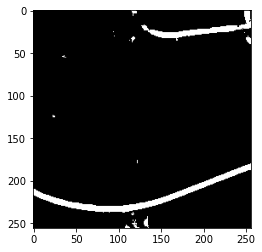

In [92]:
im = np.load('unet_output/train/threshold/0.npy')
plt.imshow(im, cmap='gray')